# Stellar Templates

The purpose of this notebook is to demonstrate the diversity in physical properties and spectral coverage of the DESI stellar templates.  In addition, the notebook directly compares the old (v2.2) and new (v3.0) stellar template set.  

Briefly, the v3.0 template set consists of 9649 templates covering the 3000-11000 A spectral range, while the v2.2 template set consists of 1491 templates covering the 1300-65000 wavelength range.  In other words, the v3.0 templates trade much finer sampling of physical parameters (*Teff*, *log-g*, and *[Fe/H]*) for less spectral coverage compared to v2.2.  However, in order to ensure we can deliver WISE fluxes from the v3.0 templates, we use the *r-W1* and *r-W2* colors synthesized from the v2.2 template set interpolated to the *Teff*, *log-g*, and *[Fe/H]* values of the v3.0 templates.

John Moustakas & Carlos Allende-Prieto  
2018 September 27

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import speclite
from desisim.io import read_basis_templates

In [3]:
import matplotlib
import seaborn as sns
%matplotlib inline

In [4]:
sns.set(style='white', font_scale=1.8, font='sans-serif')
colors = sns.color_palette('Set2', n_colors=8, desat=0.75)
#colors = iter([_colors[1], _colors[2], _colors[0], _colors[3], _colors[4]])

In [5]:
seed = 1
rand = np.random.RandomState(seed)

### Read the old (v2.2) and new (v3.0) templates here for convenience.

In [34]:
fnew, wnew, mnew = read_basis_templates('STAR')

INFO:io.py:945:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v3.0/star_templates_v3.0.fits


In [35]:
fold, wold, mold = read_basis_templates('STAR', infile=os.path.join(
    os.getenv('DESI_ROOT'), 'spectro', 'templates', 
    'basis_templates', 'v2.6', 'star_templates_v2.2.fits'))

INFO:io.py:945:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.6/star_templates_v2.2.fits


In [8]:
len(mnew), wnew.min(), wnew.max(), len(mold), wold.min(), wold.max()

(9649, 3000.9314, 11002.49, 1491, 1300.0392, 64999.832)

### Compare the coverage of physical parameter space.

In [9]:
def qa_physical(new=True):
    if new:
        meta = mnew
        title = 'v3.0 Templates'
        col = colors[0]
    else:
        meta = mold
        title = 'v2.2 Templates'
        col = colors[1]
        
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

    ax1.scatter(meta['TEFF'], meta['LOGG'], color=col)
    ax1.set_xscale('log')
    ax1.set_xticks([3000, 5000, 1E4, 2E4])
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax1.set_xlabel('$T_{eff}$ (K)')
    ax1.set_ylabel('$\log g$ (cm s$^{-2}$)')
    #ax1.legend(loc='lower right', fontsize=10, markerscale=1.0)

    ax2.scatter(meta['TEFF'], meta['FEH'], color=col)
    ax2.set_xscale('log')
    ax2.set_xticks([3000, 5000, 1E4, 2E4])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax2.set_xlabel('$T_{eff}$ (K)')
    ax2.set_ylabel('[Fe/H]')

    ax3.scatter(meta['LOGG'], meta['FEH'], color=col)
    ax3.set_ylabel('[Fe/H]')
    ax3.set_xlabel('$\log g$ (cm s$^{-2}$)')
    
    fig.suptitle(title, fontsize=18)

    fig.subplots_adjust(wspace=0.22)

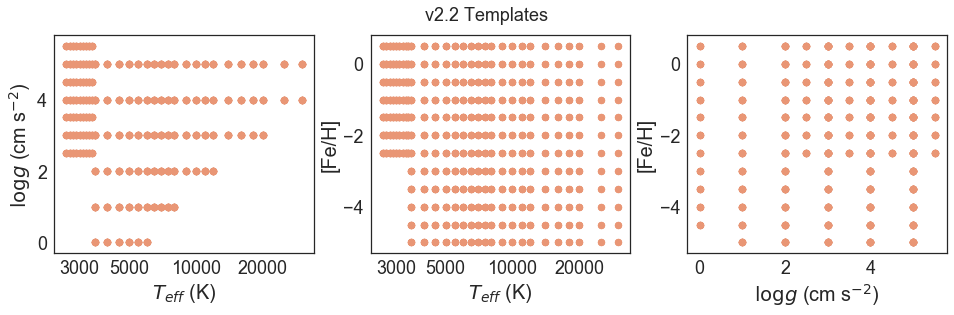

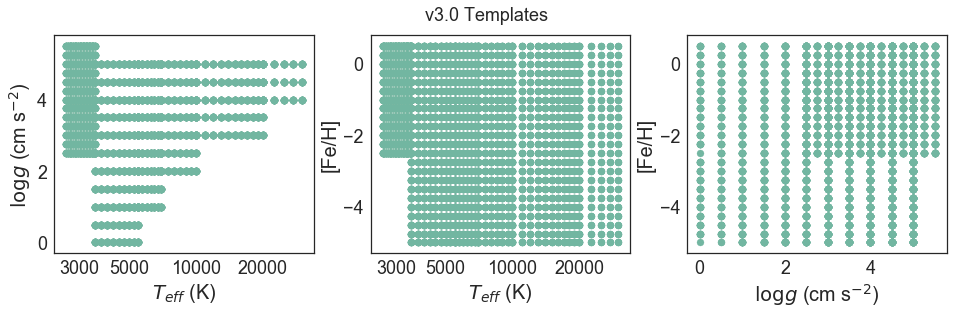

In [10]:
qa_physical(new=False)
qa_physical(new=True)

### Directly compare the v2.2 and v3.0 templates

### Color-color plots

In [11]:
class star_KDTree(object):
    def __init__(self, meta):
        
        logteff = np.log10(meta['TEFF'].data)
        logg = meta['LOGG']
        feh = meta['FEH']

        self.param_min = ( logteff.min(), logg.min(), feh.min() )
        self.param_range = ( np.ptp(logteff), np.ptp(logg), np.ptp(feh) )

        self.KDTree = self.KDTree_build( np.vstack((logteff, logg, feh)).T )

    def KDTree_rescale(self, matrix):
        """Normalize input parameters to [0, 1]."""
        nobj, ndim = matrix.shape
        
        return ( (matrix - np.tile(self.param_min, nobj).reshape(nobj, ndim)) /
                 np.tile( self.param_range, nobj).reshape(nobj, ndim) )
    
    def KDTree_build(self, matrix):
        """Build a KD-tree."""
        from scipy.spatial import cKDTree as KDTree
        return KDTree( self.KDTree_rescale(matrix) )

    def KDTree_query(self, matrix, return_dist=False):
        """Return the nearest template number based on the KD Tree."""

        dist, indx = self.KDTree.query( self.KDTree_rescale(matrix) ) 

        if return_dist:
            return dist, indx
        else:
            return indx

In [31]:
def plot_subset(nplot=32, ncol=4, these=None, xlim=(3000, 10000), 
                loc='right', targname='', objtype='', seed=None):
    """Plot a random sampling of new and old stellar spectra."""        

    rand = np.random.RandomState(seed)
    
    nrow = np.ceil(nplot / ncol).astype('int')

    # Choose a random subset of the old templates and then find 
    # the nearest (in physical parameter space) new template.
    if these is None:
        tree = star_KDTree(mnew)
        indxold = rand.choice(len(mold), nplot, replace=False)
        #indxold = indxold[np.argsort(mold['TEFF'][indxold])]
        
        indxnew = tree.KDTree_query( np.vstack((
            np.log10(mold['TEFF'][indxold]),
            mold['LOGG'][indxold], mold['FEH'][indxold])).T )
        #print(mold['TEFF'][indxold].data / mnew['TEFF'][indxnew].data)
        #print(indxold, indxnew)
        
    w1 = (wold > 5500) * (wold < 5550)
    w2 = (wnew > 5500) * (wnew < 5550)

    fig, ax = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow), 
                           sharey=False, sharex=True)
    for thisax, iold, inew in zip(ax.flat, indxold, indxnew):
        thisax.plot(wold, fold[iold, :] / np.median(fold[iold, w1]))
        thisax.plot(wnew, fnew[inew, :] / np.median(fnew[inew, w2]))
        
        lbl0 = 'ID: {}, {}'.format(iold, inew)
        lbl1 = r'Teff: ${:.2f}, {:.2f}$'.format(mold['TEFF'][iold], mnew['TEFF'][inew])
        lbl2 = r'logg: ${:.2f}, {:.2f}$'.format(mold['LOGG'][iold], mnew['LOGG'][inew])
        lbl3 = r'[Fe/H]: ${:.2f}, {:.2f}$'.format(mold['FEH'][iold], mnew['FEH'][inew])
        #label = 'Old={}, New={}'.format(iold, inew)
        label = lbl0+'\n'+lbl1+'\n'+lbl2+'\n'+lbl3
        #label = 'Old={}, New={}'.format(iold, inew)
        
        if mold['TEFF'][iold] >= 4500:
            xtxt, ytxt, ha = 0.93, 0.93, 'right'
        else:
            xtxt, ytxt, ha = 0.05, 0.93, 'left'
        thisax.text(xtxt, ytxt, label, ha=ha, va='top', 
                    transform=thisax.transAxes, fontsize=13)
            
        thisax.xaxis.set_major_locator(plt.MaxNLocator(3))
        #thisax.set_xscale('log')
        #thisax.set_yscale('log')
        
        if xlim:
            thisax.set_xlim(xlim)
    for thisax in ax.flat:
        thisax.yaxis.set_ticks([])
        thisax.margins(0.2)
        
    fig.suptitle(targname)
    fig.subplots_adjust(wspace=0.05, hspace=0.05, top=0.93)

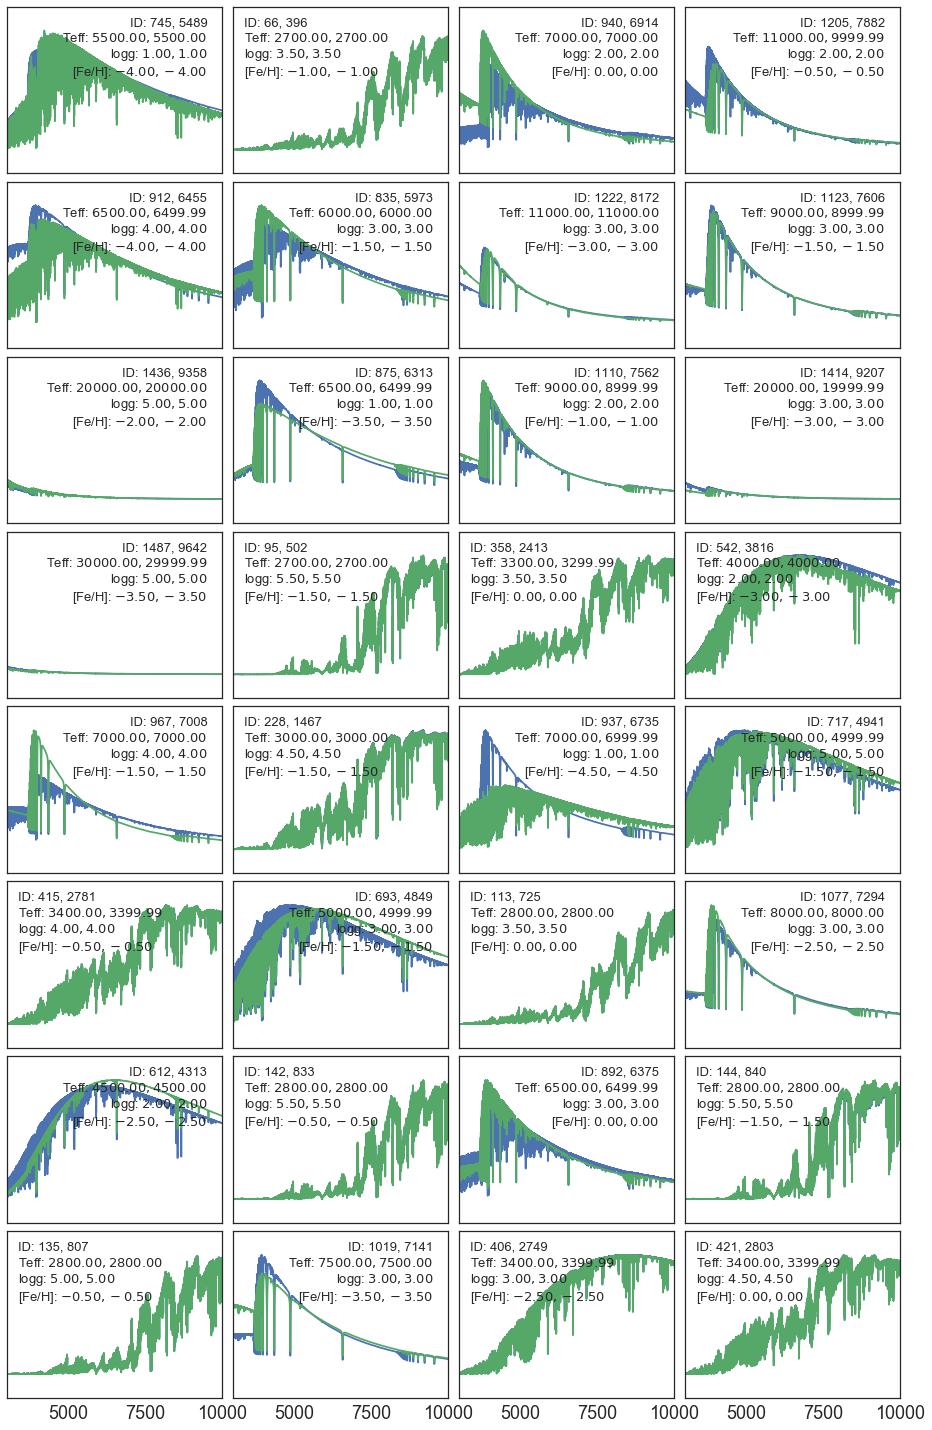

In [32]:
plot_subset()

 TEFF  LOGG FEH 
------ ---- ----
7000.0  1.0 -4.5    TEFF   LOGG FEH 
--------- ---- ----
6999.9897  1.0 -4.5


(3000, 10000)

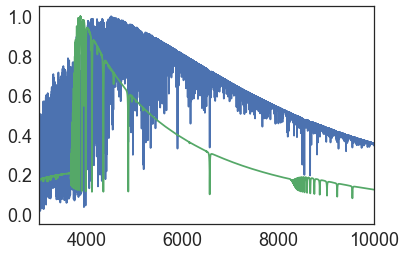

In [36]:
iold, inew = 937, 6735
print(mold['TEFF', 'LOGG', 'FEH'][iold], mnew['TEFF', 'LOGG', 'FEH'][inew])
plt.plot(wnew, fnew[inew, :] / np.max(fnew[inew, :]) )
plt.plot(wold, fold[iold, :] / np.max(fold[iold, :]) )
plt.xlim(3000, 10000)

In [17]:
stop

NameError: name 'stop' is not defined

In [ ]:
def star_colors(new=True):
    """Read the stellar templates, synthesize photometry, and return colors."""
    if new:
        bands = ('g', 'r', 'z')
        filts = ('decam2014-g', 'decam2014-r', 'decam2014-z')
        filt = speclite.filters.load_filters(*filts)
        flux, wave, meta = fnew, wnew, mnew
    else:
        bands = ('g', 'r', 'z', 'W1', 'W2')
        filts = ('decam2014-g', 'decam2014-r', 'decam2014-z', 'wise2010-W1', 'wise2010-W2')
        filt = speclite.filters.load_filters(*filts)
        flux, wave, meta = fold, wold, mold

    nt = len(meta)
    print('Synthesizing photometry for {} templates.'.format(nt))
    
    phot = filt.get_ab_maggies(flux, wave, mask_invalid=False)
    for ff, bb in zip( phot.colnames, bands ):
        phot.rename_column(ff, bb)
        #synthflux = np.vstack( [phot[ff].data for ff in filts] )
        
    colors = dict(
        r = 22.5 - 2.5 * np.log10(phot['r']),
        gr = -2.5 * np.log10(phot['g'] / phot['r']),
        rz = -2.5 * np.log10(phot['r'] / phot['z']),
        gz = -2.5 * np.log10(phot['g'] / phot['z']))
    
    if 'W1' in bands:
        colors.update( {
            'rW1': -2.5 * np.log10(phot['r'] / phot['W1']),
            'zW1': -2.5 * np.log10(phot['z'] / phot['W1']) } )

    return colors

In [ ]:
newcol = star_colors()

In [ ]:
oldcol = star_colors(new=False)

In [ ]:
grrange = (-0.6, 2.2)
gzrange = (0.0, 4.0)
rzrange = (-0.6, 2.8)
zW1range = (-2.5, 0.0)

In [ ]:
def qa_colorcolor(pickles=False, pngfile=None):
    
    fig, ax = plt.subplots(figsize=(8, 6))
    if pickles:
        ax.scatter(picklecol['rz'], picklecol['gr'], marker='s', 
                   s=20, linewidth=1, alpha=0.5, label='Pickles+98')#, c='r')
    ax.scatter(newcol['rz'], newcol['gr'], marker='s', color=colors[1],
               s=3, linewidth=1, alpha=1.0, label='v3.0 Templates')#, c='b')
    ax.scatter(oldcol['rz'], oldcol['gr'], marker='o', color=colors[0],
               s=15, linewidth=1, alpha=0.8, label='v2.2 Templates')#, c='b')
    ax.set_xlabel('r - z')
    ax.set_ylabel('g - r')
    ax.set_xlim(rzrange)
    ax.set_ylim(grrange)
    lgnd = ax.legend(loc='upper left', frameon=False, fontsize=18)
    lgnd.legendHandles[0]._sizes = [100]
    lgnd.legendHandles[1]._sizes = [100]
    if pickles:
        lgnd.legendHandles[2]._sizes = [100]
    if pngfile:
        fig.savefig(pngfile)

In [ ]:
qa_colorcolor(pickles=False)

In [ ]:
stop

In [ ]:
from desisim.templates import STAR
ss = STAR()
ff, ww, mm, oo = ss.make_templates(100, seed=seed)

In [ ]:
tree = star_KDTree()

In [ ]:
indx = self.tree.query(matrix) # no north-south split (e.g., BGS/MXXL)

In [ ]:
plot_subset()